In [1]:
import numpy as np
import healpy as hp
import matplotlib as mpl
from   matplotlib import cm
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from astropy.constants import h
from astropy.constants import k_B

T_cmb = 2.7255

mpl.rcParams['text.usetex'] = True

In [2]:
def cmb_to_rj(freq,data):
    y          = h.value*(freq*1e9)/ (k_B.value*T_cmb)
    conversion = (y**2.0*np.exp(y))/(np.exp(y)-1)**2.0
    return data*conversion

In [3]:
# SED functions, all given in units of uK_RJ
def power_law(amp,ref,x,beta):
    return amp*(x/ref)**(beta)

def mbb(amp,ref,x,td,beta):
    # Inputs need to be in GHz.
    z = h.value / (k_B.value*td)
    return amp*(np.exp(z*ref*1e9)-1.0)/(np.exp(x*1e9*z)-1.0)*(x/ref)**(beta+1.0)

# Used to shift the spdust spectrum                                                                                                                                                                                
def sdust(nu, Asd, nu_p, nuref):
    nu_ref = nuref*1e9
    nu_p0 = 30.*1e9
    nu_p *= 1e9
    
    fnu, f = np.loadtxt("../../../ame_spectra/spdust2_cnm.dat", unpack=True)
    fnu *= 1e9
    # MAKE SURE THAT THESE ARE BOTH IN 1e9                                                                                                                                                                         
    scale = nu_p0/nu_p

    f = np.interp(scale*nu*1e9, fnu, f)
    f0 = np.interp(scale*nu_ref, scale*nu*1e9, f) # Value of s at nu_0
    # Move from intensity to uK_RJ
    s_sd = (nu_ref/nu*1e9)**2*f/f0
    return s_sd/np.max(s_sd)

In [4]:
def mask_maps(mask,pol):
    for i in range(len(mask)):
        if (pol == 'Q'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_Q_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_Q_scaled[i]   = np.nan
        elif (pol == 'U'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_U_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_U_scaled[i]   = np.nan
        elif (pol == 'P'):
            if (mask[i] == hp.UNSEEN):
#                 I_ame_over_I_353[i] = 0.0 
#                 synch_P_scaled[i]   = 0.0
                I_ame_over_I_353[i] = np.nan
                synch_P_scaled[i]   = np.nan
        else:
            print("Unusable pol type (use 'Q', 'U', or 'P').")
            
def sky_frac(map):
    masked = 0
    for i in range(len(map)):
        if (map[i] == hp.UNSEEN):
            masked += 1
            
    print('Sky fraction: ', 1.-masked/len(map))

In [5]:
def read_params(filename):
    labels = []
    freq   = []
    with open(filename,'r') as infile:
        for line in infile:
            if line.startswith('NUMBAND'):
                numbands = int(line.split('=')[1])
            if line.startswith('NUMGIBBS'):
                numgibbs = int(line.split('=')[1][:5])
                
    blabs = []
    bfreq = []
    for band in range(numbands):
        blabs.append('BAND_LABEL'+str(band+1).zfill(2))
        bfreq.append('BAND_FREQ'+str(band+1).zfill(2))        
    for band in range(numbands):
         with open(filename,'r') as infile:
            for line in infile:
                if line.startswith(blabs[band]):
                    name = str.strip(line.split('=')[1])
                    labels.append(name)
                if line.startswith(bfreq[band]):
                    fre  = str.strip(line.split('=')[1])
                    freq.append(float(fre))
    return labels, freq, numgibbs

In [6]:
dir     = str(input('Which directory are we wanting to plot from? '))
version = dir[dir.index('v'):dir.index('v')+3]
print(version)

Which directory are we wanting to plot from?  vec_test


vec


In [7]:
names, freq, num_samp = read_params('../'+dir+'/param_'+dir+'.txt')
labels = [name.replace("'","") for name in names]
labels = [w.replace("_","\_") for w in labels]
num_bands = len(freq)
print(labels)
print(freq)

['bp\\_030', 'bp\\_044', 'bp\\_070', 'wmap\\_Ka', 'wmap\\_Q']
[28.4, 44.1, 70.3, 33.0, 40.6]


In [8]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
ame_map      = hp.read_map('/home/daniel/data/planck_products/COM_CompMap_AME-commander_0064_R2.00.fits',field=0,verbose=False)
npix         = len(ame_map)

In [10]:
dust_353     = hp.read_map('../data/npipe6v20_353_map_n0064_60arcmin_uK.fits',field=(0,1,2),verbose=False)
dust_353_rms = hp.read_map('../data/npipe6v20_353_n0064_rms_tqu_uK.fits',field=(0,1,2),verbose=False)
synch_Q_044  = hp.read_map('../'+dir+'/synch_Q_mean.fits',verbose=False)
synch_U_044  = hp.read_map('../'+dir+'/synch_U_mean.fits',verbose=False)
dust_Q_amps  = np.loadtxt('../'+dir+'/dust_Q_amplitudes.dat')
# dust_Q_unc   = np.loadtxt('../'+dir+'/dust_Q_uncertainties.dat')
dust_U_amps  = np.loadtxt('../'+dir+'/dust_U_amplitudes.dat')
# dust_U_unc   = np.loadtxt('../'+dir+'/dust_U_uncertainties.dat')

In [11]:
# Planck 2015 2 component AME details
ame_comp1 = [92.,22.8,20.]   #<A_SD>,ref and peak freqs in GHz
ame_comp2 = [18.,40.1,33.35] #<A_SD>,ref and peak freqs in GHz

In [12]:
# Some plotting array of frequencies
x = np.linspace(5,1000,1000)

In [13]:
dust_353     = cmb_to_rj(353,dust_353)
dust_353_rms = cmb_to_rj(353,dust_353_rms)

In [14]:
dust_353_P   = np.empty(len(synch_Q_044))
dust_P_rms   = np.empty(len(synch_Q_044))
synch_P_044  = np.empty(np.shape(synch_Q_044))
dust_P_amps  = np.empty(np.shape(dust_Q_amps))

print(np.shape(dust_Q_amps))
num_samp = np.shape(dust_Q_amps)[0]
# dust_P_unc   = np.empty(len(dust_Q_unc))

dust_Q_means = np.empty(np.shape(dust_Q_amps)[1])
dust_U_means = np.empty(np.shape(dust_U_amps)[1])
dust_P_means = np.empty(np.shape(dust_Q_means))
dust_Q_std   = np.empty(np.shape(dust_Q_amps)[1])
dust_U_std   = np.empty(np.shape(dust_U_amps)[1])
dust_P_std   = np.empty(np.shape(dust_Q_means))

# dust_Q_amps *= 12.9055
# dust_U_amps *= 12.9055

for i in range(npix):
    dust_353_P[i]  = np.sqrt(dust_353[1][i]**2 + dust_353[2][i]**2)
    dust_P_rms[i]  = np.sqrt(dust_353_rms[1][i]**2 + dust_353_rms[2][i]**2)
    if False:
        for j in range(num_samp):
            synch_P_044.T[j][i] = np.sqrt(synch_Q_044.T[j][i]**2 + synch_U_044.T[j][i]**2)
    else:
        synch_P_044[i] = np.sqrt(synch_Q_044[i]**2 + synch_U_044[i]**2)

for i in range(num_samp):
    for j in range(num_bands):
        dust_P_amps[i][j] = np.sqrt(dust_Q_amps[i][j]**2 + dust_U_amps[i][j]**2)
    
# for i in range(len(dust_Q_unc)):
#     dust_P_unc[i] = np.sqrt(dust_Q_unc[i]**2 + dust_U_unc[i]**2)

for i in range(len(dust_Q_means)):
    dust_Q_means[i] = np.mean(dust_Q_amps.T[:][i])
    dust_U_means[i] = np.mean(dust_U_amps.T[:][i])
    dust_P_means[i] = np.sqrt(dust_Q_means[i]**2 + dust_U_means[i]**2)
    dust_Q_std[i]   = np.std(dust_Q_amps.T[:][i])
    dust_U_std[i]   = np.std(dust_U_amps.T[:][i])
    dust_P_std[i]   = np.std(dust_P_amps.T[:][i])
   
    
print(dust_Q_means,dust_Q_std)#,dust_Q_unc)
print(dust_U_means,dust_U_std)#,dust_U_unc)
print(dust_P_means,dust_P_std)#,dust_P_unc)

(100, 5)
[0.         0.0339777  0.         0.07042314 0.04565617] [0.         0.00106126 0.         0.00072685 0.00094762]
[0.         0.0339777  0.         0.07042314 0.04565617] [0.         0.00106126 0.         0.00072685 0.00094762]
[0.         0.04805173 0.         0.09959335 0.06456757] [0.         0.00150085 0.         0.00102792 0.00134014]


In [15]:
planck_XI_freq = [44.1,70.3]
planck_XI_mean = [6.0e-3,9.46e-3]
planck_XI_err  = [1.1e-3,0.75e-3]

for i in range(2):
#     planck_XI_mean[i] = cmb_to_rj(353.,planck_XI_mean[i])
#     planck_XI_err[i]  = cmb_to_rj(353.,planck_XI_err[i])
    planck_XI_mean[i] = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_mean[i])
    planck_XI_err[i]  = 1/(cmb_to_rj(353.,1.0))*cmb_to_rj(planck_XI_freq[i],planck_XI_err[i])
   
print(planck_XI_mean)
print(planck_XI_err)

[0.0736564217277, 0.10762147257140103]
[0.013503677316745, 0.008532357762003251]


In [16]:
# This approach will be to divide each map by the actual npip26v20 353 (Q or U) map for normalization
# In essence, this means that in our 'units', the npipe6v20 is equal to 1.0 everywhere.
mono_dip       = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False,fitval=True)
# print(mono_dip[1])
dust_353[0][:] = hp.remove_dipole(dust_353[0][:],gal_cut=75,verbose=False) + mono_dip[1]

synch_Q_scaled = synch_Q_044/dust_353[1]
synch_U_scaled = synch_U_044/dust_353[2]
synch_P_scaled = synch_P_044/dust_353_P

In [17]:
# The idea here is that if the AME is as polarized as dust, then
# Q_{AME}/Q_{dust,353} = I_{AME}/I_{dust,353} <- cmb corrected of course

I_ame_over_I_353    = ame_map/dust_353[0][:]

In [18]:
# Make signal to noise maps 
s_n_Q        = dust_353[1][:]/dust_353_rms[1][:]
s_n_U        = dust_353[2][:]/dust_353_rms[2][:]
s_n_P        = dust_353_P/dust_P_rms
mask_Q       = np.empty(len(s_n_Q))
mask_U       = np.empty(len(s_n_U))
mask_P       = np.empty(len(s_n_P))

# Write something here about choosing a pixel, or s/n ratio for a sky fraction

sn_lim = float(input('Signal to noise limit: '))

npix = len(synch_Q_044)
Q_masked = 0
U_masked = 0
P_masked = 0

Signal to noise limit:  1


In [19]:
for i in range(len(s_n_Q)):
    if (np.abs(s_n_Q[i]) > sn_lim):
        mask_Q[i] = 1.0
    else:
        Q_masked += 1
        mask_Q[i] = hp.UNSEEN
        s_n_Q[i]  = hp.UNSEEN

    if (np.abs(s_n_U[i]) > sn_lim):
        mask_U[i] = 1.0
    else:
        U_masked += 1
        mask_U[i] = hp.UNSEEN
        s_n_U[i]  = hp.UNSEEN
        
    if (np.abs(s_n_P[i]) > sn_lim):
        mask_P[i] = 1.0
    else:
        P_masked += 1
        mask_P[i] = hp.UNSEEN
        s_n_P[i]  = hp.UNSEEN

In [20]:
spdust_tot  = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
spdust_tot  = spdust_tot/np.max(spdust_tot)

In [21]:
mask_maps(mask_Q,'Q')
sky_frac(mask_Q)
mask_maps(mask_U,'U')
sky_frac(mask_U)
mask_maps(mask_P,'P')
sky_frac(mask_P)

# hp.mollview(I_ame_over_I_353,min=-1,max=1)
# plt.show()

# hp.write_map('mask_dust_P_s_n_n0064_60arcmin.fits',mask_P)
# hp.mollview(mask_P)
# plt.show()

ame_over_353_median = np.nanmedian(I_ame_over_I_353)
ame_over_353_mean   = np.nanmean(I_ame_over_I_353)
print(ame_over_353_median)
print(ame_over_353_mean)
spdust_tot *= ame_over_353_mean


Sky fraction:  0.8642578125
Sky fraction:  0.8453165690104166
Sky fraction:  0.94281005859375
0.5318871908865608
0.5617103014809224


In [22]:
# ame_col = ['yellow','gold','orange','darkorange','orangered']
ame_col = ['goldenrod','orange','darkorange','chocolate','saddlebrown']
amp_col = ['royalblue','cadetblue','steelblue','darkturquoise','cyan']
colors = [cm.plasma(i) for i in np.linspace(0, 1, 12)]

In [23]:
s_Q_mean = np.nanmean(synch_Q_scaled)
s_Q_std  = np.nanstd(synch_Q_scaled)
s_Q_low  = s_Q_mean - s_Q_std
s_Q_high = s_Q_mean + s_Q_std
print("Q",s_Q_low,s_Q_mean,s_Q_high)

s_U_mean = np.nanmean(synch_U_scaled)
s_U_std  = np.nanstd(synch_U_scaled)
s_U_low  = s_U_mean - s_U_std
s_U_high = s_U_mean + s_U_std
print("U",s_U_low,s_U_mean,s_U_high)

s_P_mean = np.nanmean(synch_P_scaled)
s_P_std  = np.nanstd(synch_P_scaled)
s_P_low  = s_P_mean - s_P_std
s_P_high = s_P_mean + s_P_std
print("P",s_P_low,s_P_mean,s_P_high)

Q -0.8105560591813701 0.37546381928413736 1.5614836977496447
U -1.0801634037571357 0.3368036562519456 1.753770716261027
P -0.018069765466731336 0.7480946712025757 1.5142591078718826


In [28]:
def fit_ame_2_amps(sdust,mbb,x,amps,freqs,err):
    pols  = np.linspace(0,1.0,1000)
    chisq = np.empty(1000)
    
    for i in range(1000):
        sig = mbb+pols[i]*sdust
        for j in range(len(amps)):
            chisq[i] += ((amps[j]-np.interp(freqs[j],x,sig))**2)/(err[j]**2)
     
    indx = np.where(chisq == np.min(chisq))
    pmax = 22*pols
    post = np.exp(-0.5*chisq)
    norm = cumtrapz(post,pols)
    
#     cumul = np.cumsum(post)
    
#     dummy = np.empty(1000)

#     xfill = np.where(cumul/cumul[-1] < 0.95)[-1]
        
    print(post)
        
    plt.plot(pmax,chisq)#/norm)
    plt.show()
        
#     plt.figure(figsize=(8,6))
#     plt.plot(pmax,post/norm)
#     plt.xlabel(r'$p_{\rm max}\, [{\rm \%}]$',size=20)
#     plt.ylabel(r'$p(p_{\rm max}\,|A_{\rm d},\,A_{\rm s},\,{\rm d})$',size=20)
#     plt.xlim([0,22])
# #     plt.fill_between(pmax[:xfill[-1]],dummy[:xfill[-1]],post[:xfill[-1]]/norm,color='blue',alpha=0.4,label=r'${\rm 95\,\%\, Confidence\, Interval}$')
#     plt.ylim([0,4])
#     plt.rc('ytick',labelsize=12)
#     plt.rc('xtick',labelsize=12)
#     plt.legend(prop={'size': 15})
#     plt.savefig('../P_amp_bestfit_posterior_v28.pdf',dpi=300,bbox_inches='tight')
#     plt.show()

[0.033977703430000006, 0.07042313509000002, 0.045656168320000017]
[0.0010612643420462615, 0.0007268494505862834, 0.0009476236648404457]
[44.1, 33.0, 40.6]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

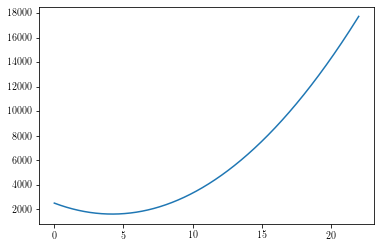

In [29]:
t_err   = []
t_amps  = []
t_freqs = []
for i in range(len(dust_Q_means)):
    if dust_P_means[i] != 0.0:
        t_amps.append(dust_Q_means[i])
        t_err.append(dust_Q_std[i])
        t_freqs.append(freq[i])
        
print(t_amps)        
print(t_err)
print(t_freqs)

fit_ame_2_amps(spdust_tot,mbb(1.0,353.,x,19.6,1.53),x,t_amps,t_freqs,t_err)

In [30]:
def plot_Q_Q353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_Q_mean,44.0,x,-3.1),color='gray',label='Synchrotron Mean')#,alpha=0.35)
#     ax.plot(x,power_law(s_Q_high,30.0,x,-3.1),color='green',linestyle='--')
#     ax.fill_between(x,power_law(s_Q_low,30.0,x,-3.1),power_law(s_Q_high,30.0,x,-3.1),color='Green',alpha=0.2)

    # MBB Plotting
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.7),color='red',label='Thermal Dust')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.6),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.6$',linestyle='--')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.5),color='red',label=r'$T_d = 19.6K,\, \beta_d = 1.3$',linestyle='-.')

    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=colors[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=colors[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=colors[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color=colors[5],label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB

#     ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=ame_col[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
#     ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=ame_col[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
#     ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=ame_col[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
#     ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=ame_col[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
#     ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=ame_col[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
#     ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color='red',label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB

    k = 0
    ax.scatter(freq,dust_Q_means,label='This work',color='k',zorder=10)
    ax.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10)
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='red',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_Q_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-2,2e0])
        ax.set_xlim([10,200.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_xticks([10, 40, 100])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#     ax.set_title('AME Pol '+version+' - Q Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$Q/Q_{353}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1,)# prop={'size': 15})
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_Q353_sample_'+str(sample)+'_'+version+'.png',dpi=300,bbox_inches='tight')
#     plt.show()

def plot_U_U353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(x,power_law(s_U_mean,44.0,x,-3.1),color='gray',label='Synchrotron Mean')#,alpha=0.35)

    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=colors[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=colors[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=colors[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color=colors[5],label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB

    k = 0
    ax.scatter(freq,dust_U_means,label='This work',color='k',zorder=10)
    ax.errorbar(freq,dust_U_means,dust_U_std,fmt='.',color='k',zorder=10)
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='red',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_U_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-2,2e0])
        ax.set_xlim([10,200.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_xticks([10, 40, 100])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#     ax.set_title('AME Pol '+version+' - Q Amplitudes - S/N = '+str(sn_lim),size=20)
    ax.set_ylabel(r'$U/U_{353}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1,)# prop={'size': 15})
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_U353_sample_'+str(sample)+'_'+version+'.png',dpi=300,bbox_inches='tight')
#     plt.show()
    
def plot_P_P353(sample):
    fig, ax = plt.subplots(figsize=(10,8))

    # Synch
    ax.fill_between(x,power_law(s_Q_mean,44.0,x,-3.1),power_law(s_U_mean,44.0,x,-3.1),color='gray',alpha=0.2)
    
    # MBB + AME Pol
    ax.plot(x,spdust_tot+mbb(1.0,353.,x,19.6,1.53),color=colors[0],label=r'$p_{\mathrm{AME}}^{max} = 22\%$')
    ax.plot(x,spdust_tot*0.5+mbb(1.0,353.,x,19.6,1.53),color=colors[1],label=r'$p_{\mathrm{AME}}^{max} = 11\%$')
    ax.plot(x,spdust_tot*0.25+mbb(1.0,353.,x,19.6,1.53),color=colors[2],label=r'$p_{\mathrm{AME}}^{max} = 5.5\%$')
    ax.plot(x,spdust_tot*0.1+mbb(1.0,353.,x,19.6,1.53),color=colors[3],label=r'$p_{\mathrm{AME}}^{max} = 2.2\%$')
    ax.plot(x,spdust_tot*0.05+mbb(1.0,353.,x,19.6,1.53),color=colors[4],label=r'$p_{\mathrm{AME}}^{max} = 1.1\%$')
    ax.plot(x,mbb(1.0,353.,x,19.6,1.53),color=colors[5],label=r'$p_{\mathrm{AME}}^{max} = 0\%$') # Planck 2018 Dust Pol MBB
    
    # Fit dust amplitudes
    k = 0
    ax.scatter(freq,dust_Q_means,label='This work',color='k',zorder=10)
    ax.errorbar(freq,dust_Q_means,dust_Q_std,fmt='.',color='k',zorder=10)
    ax.errorbar(planck_XI_freq,planck_XI_mean,yerr=planck_XI_err,color='red',fmt='.',zorder=10,label='Planck XI EE')
    if all(i >= 0.0 for i in dust_U_amps[0][:]):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim([1e-2,2e0])
        ax.set_xlim([10,200.])
    else:
        ax.set_ylim([-0.01,0.1])
        ax.set_xlim([5,100])
    ax.set_xticks([10, 40, 100])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylabel(r'$A/A_{353}\, [\mathrm{Brightness\, Temperature\, Units}]$',size=20)
    ax.set_xlabel(r'$\mathrm{Frequency\, [GHz]}$',size=20)
    ax.legend(loc=1)
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)
    plt.savefig('../'+dir+'/sed_fgs_P353_sample_'+str(sample)+'_'+version+'.pdf',dpi=300,bbox_inches='tight')
#     plt.show()    

In [ ]:
plot_Q_Q353('mean')

In [ ]:
plot_U_U353('mean')

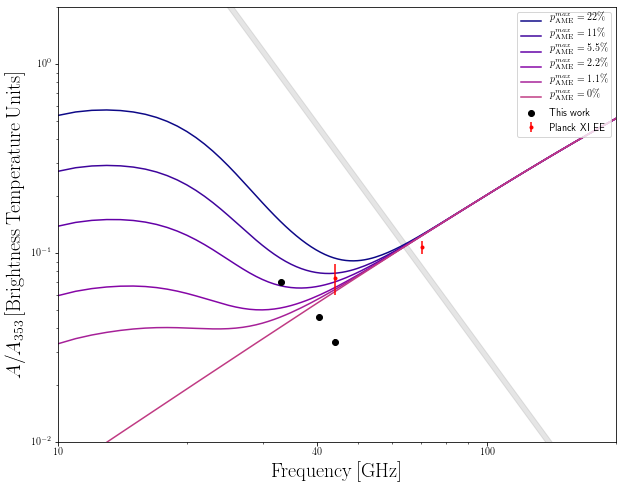

In [31]:
plot_P_P353('mean')

In [ ]:
def sim_data(freq):
    ame = ame_comp1[0]*sdust(x,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(x,ame_comp2[0],ame_comp2[2],ame_comp2[1])
    ame = ame/np.max(ame)*ame_over_353_mean
    sp_amp = np.interp(freq,x,ame)
#     sp_amp = ame_comp1[0]*sdust(freq,ame_comp1[0],ame_comp1[2],ame_comp1[1]) + ame_comp2[0]*sdust(freq,ame_comp2[0],ame_comp2[2],ame_comp2[1])
#     sp_amp = sp_amp/np.max(ame)*ame_over_353_mean
    print('Frequency',freq)
    print('Thermal',mbb(1.0,353.,freq,19.6,1.53))
    print('AME 22%',sp_amp)
    print('Synch',power_law(1.0,30.0,freq,-3.1))
    print('')
#     plt.loglog(x,ame)
#     plt.ylim([1e-4,1e3])
#     plt.loglog(x,power_law(1.0,30.0,x,-3.1))
#     plt.loglog(x,mbb(1.0,353.,x,19.6,1.53))
#     plt.show()

In [ ]:
# print(cmb_to_rj(33.0,1.0))
sim_data(20.)
sim_data(30.)
sim_data(45.)
sim_data(70.)
sim_data(100.)